In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-11-24 11:08:30--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.253.122.128, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   152MB/s    in 1.5s    

2020-11-24 11:08:32 (152 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



## Parameters

In [3]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 160000
test_portion=.1


## Load Data

In [4]:
def load_data(path):
  num_sentences = 0
  corpus = []

  with open(path) as csvfile:
      reader = csv.reader(csvfile, delimiter=',')
      for i, row in enumerate(reader):
        label = int(row[0])
        text = row[5]
        if label >0:
          label = 1
        list_item =[text, label]
        num_sentences = num_sentences + 1
        corpus.append(list_item)
  return corpus, num_sentences

In [5]:
corpus, num_sentences = load_data(path="/tmp/training_cleaned.csv")

In [6]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


## Training Subset

In [7]:
def train_data(corpus, tr_size):
  sentences = []
  labels = []

  for i in range(tr_size):
    sentences.append(corpus[i][0])
    labels.append(corpus[i][1])
  return sentences, labels


In [8]:
random.shuffle(corpus)
sentences, labels = train_data(corpus, tr_size=training_size)

## Tokenize

In [9]:
def tokenize(sentences):

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sentences)

  sequences = tokenizer.texts_to_sequences(sentences)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  return padded, tokenizer

In [10]:
padded, tokenizer = tokenize(sentences)


In [11]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

## Train- Test Split

In [12]:
def train_test_split(seq, labels, test_portion):
  split_index = int(len(labels)*test_portion)

  xtrain = np.array(seq[split_index:])
  ytrain = np.array(labels[split_index:])
  xtest =  np.array(seq[:split_index])
  ytest =  np.array(labels[:split_index])

  return (xtrain, ytrain), (xtest, ytest)

In [13]:
(train_sequences, train_labels), (test_sequences, test_labels) = train_test_split(padded, labels, test_portion)

In [14]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138781
1


## Load Pre-trained Embeddings

In [15]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-11-24 11:08:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.217.7.176, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  87.9MB/s    in 3.8s    

2020-11-24 11:08:48 (87.9 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [16]:
def load_embedding_layer(path, word_index, vocab_size):
  embeddings_index = {}
  with open(path) as f:
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype="float32")
      embeddings_index[word] = coefs
  embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embeddings_matrix[i] = embedding_vector

  return embeddings_matrix

In [17]:
embeddings_matrix = load_embedding_layer(path='/tmp/glove.6B.100d.txt', word_index=word_index, vocab_size=vocab_size)

In [18]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138782


## Model

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(1e-5))
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           13878200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 13,943,353
Trainable params: 65,153
Non-trainable params: 13,878,200
_____________________________________

## Training

In [24]:
num_epochs = 50
history = model.fit(train_sequences, train_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Epoch 1/50
4500/4500 - 16s - loss: 0.5660 - accuracy: 0.7003 - val_loss: 0.5288 - val_accuracy: 0.7289
Epoch 2/50
4500/4500 - 15s - loss: 0.5253 - accuracy: 0.7328 - val_loss: 0.5153 - val_accuracy: 0.7419
Epoch 3/50
4500/4500 - 15s - loss: 0.5096 - accuracy: 0.7440 - val_loss: 0.5086 - val_accuracy: 0.7456
Epoch 4/50
4500/4500 - 16s - loss: 0.4980 - accuracy: 0.7518 - val_loss: 0.5038 - val_accuracy: 0.7494
Epoch 5/50
4500/4500 - 16s - loss: 0.4896 - accuracy: 0.7587 - val_loss: 0.5040 - val_accuracy: 0.7483
Epoch 6/50
4500/4500 - 16s - loss: 0.4828 - accuracy: 0.7614 - val_loss: 0.5031 - val_accuracy: 0.7489
Epoch 7/50
4500/4500 - 17s - loss: 0.4755 - accuracy: 0.7661 - val_loss: 0.5022 - val_accuracy: 0.7527
Epoch 8/50
4500/4500 - 16s - loss: 0.4718 - accuracy: 0.7695 - val_loss: 0.5020 - val_accuracy: 0.7561
Epoch 9/50
4500/4500 - 16s - loss: 0.4666 - accuracy: 0.7721 - val_loss: 0.5056 - val_accuracy: 0.7516
Epoch 10/50
4500/4500 - 16s - loss: 0.4631 - accuracy: 0.7740 - val_loss:

## Plot Performance

<Figure size 432x288 with 0 Axes>

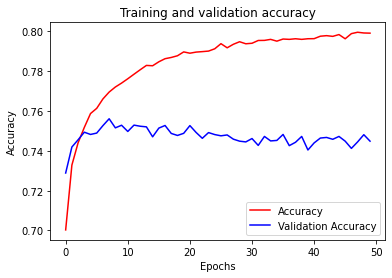

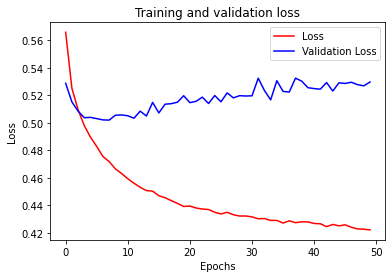

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!